# Imports

In [1]:
#Importar librerías necesarias para desarrollar el análisis
import importlib
import warnings

import pandas as pd
import numpy as np
import sklearn 
from sklearn.metrics import mean_squared_error, auc, log_loss, roc_auc_score, accuracy_score, confusion_matrix, classification_report, f1_score, recall_score, precision_score, make_scorer
import random as python_random
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy.stats import ks_2samp
import scorecardpy as sc
#import openpyxl

from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, Binarizer, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, PowerTransformer
from sklearn.impute import SimpleImputer, KNNImputer

from sklearn.feature_selection import SelectKBest, chi2, RFE, mutual_info_classif
from sklearn.model_selection import train_test_split 
from sklearn.pipeline import make_pipeline, Pipeline 
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.svm import SVC

from sklearn.metrics import roc_curve, auc, log_loss, roc_auc_score, accuracy_score, confusion_matrix, classification_report, f1_score, recall_score, precision_score, make_scorer

from sklearn.model_selection import KFold, ShuffleSplit, LeaveOneOut, StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 

from xgboost import XGBClassifier
from xgboost import XGBRegressor
import xgboost

import sys
import notebook
import jupyterlab

import os
from pathlib import Path

/Users/cristian/Documents/GitHub/adeslas-interview/.venv/lib/python3.13/site-packages/scorecardpy/germancredit.py:5: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
from dotenv import load_dotenv, find_dotenv
# Carga el .env más cercano hacia arriba en el árbol
load_dotenv(find_dotenv())

# Raíz del proyecto = carpeta que contiene el .env
PROJECT_ROOT = Path(find_dotenv()).parent

# DATA_PATH puede ser relativo (./data) o absoluto; aquí lo resolvemos desde el root
DATA_PATH = (PROJECT_ROOT / os.environ.get("DATA_PATH", "data")).resolve()

In [3]:
import sys, platform
print(sys.executable)
print(platform.python_version())

/Users/cristian/Documents/GitHub/adeslas-interview/.venv/bin/python
3.13.7


In [4]:
pd.set_option("display.max_columns", None)   # muestra todas las columnas
pd.set_option("display.width", 0)            # usa el ancho de la celda de Jupyter
pd.set_option("display.max_colwidth", None)  # no truncar el contenido de celdas

# Env

In [5]:
PROJ_ROOT = Path.cwd().parent 
sys.path.insert(0, str(PROJ_ROOT / "src"))


# Verifica
print("Añadido a sys.path:", sys.path[0])

from utils import feature_selection as fs

Añadido a sys.path: /Users/cristian/Documents/GitHub/adeslas-interview/src


# Funciones

# Load data

In [6]:
DATA_PATH = Path(os.environ["DATA_PATH"])

In [7]:
file_tab = DATA_PATH / "df_muestra_vars_eng.csv"
df_muestra_vars_eng = pd.read_csv(file_tab)
print(df_muestra_vars_eng.shape)



file_tab = DATA_PATH / "X_train.csv"
X_train = pd.read_csv(file_tab)
print(X_train.shape)

file_tab = DATA_PATH / "X_val.csv"
X_val = pd.read_csv(file_tab)
print(X_val.shape)

file_tab = DATA_PATH / "X_test.csv"
X_test = pd.read_csv(file_tab)
print(X_test.shape)



file_tab = DATA_PATH / "y_train.csv"
y_train = pd.read_csv(file_tab)
print(len(y_train))


file_tab = DATA_PATH / "y_val.csv"
y_val = pd.read_csv(file_tab)
print(len(y_val))


file_tab = DATA_PATH / "y_test.csv"
y_test = pd.read_csv(file_tab)
print(len(y_test))


selected_vars = pd.read_csv(DATA_PATH / "selected_vars.csv")["feature"].astype(str).tolist()
print(len(selected_vars))

(47547, 420)
(28528, 418)
(9510, 418)
(9509, 418)
28528
9510
9509
20


# Model - XGBoost con parametros estandar

In [8]:
# =========================
# Entrenamiento
# =========================
from utils.model_training import (
    train_xgb_binary,
    evaluate_model,
    save_artifacts,
    default_xgb_params,
)

# (Opcional) ajustar algunos hiperparámetros base
params = default_xgb_params() | dict(
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
)

results = train_xgb_binary(
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    selected_vars=selected_vars,
    xgb_params=params,
    early_stopping_rounds=100,
)

print("Best iteration:", results.best_iteration)
print("n_estimators efectivos:", results.best_n_estimators)
display(results.metrics)



Best iteration: 2
n_estimators efectivos: 3


,auc,ks,prauc,n
split,,,,
train,0.816360,0.484141,0.160692,28528
val,0.674062,0.268752,0.093998,9510


In [9]:

# =========================
# Evaluación en Test
# =========================
from utils.model_training import to_1d_series

X_te = X_test[[c for c in selected_vars if c in X_test.columns]].copy()
y_te = to_1d_series(y_test)

eval_test = evaluate_model(results.model, splits={"test": (X_te, y_te)})
print("\nMétricas test:")
display(eval_test)




Métricas test:


,auc,ks,prauc,n
split,,,,
test,0.661152,0.234796,0.088275,9509


In [10]:
# =========================
# Guardado de artefactos
# =========================
#ARTIF_PATH = DATA_PATH / "models"
#model_path, feats_path = save_artifacts(results, ARTIF_PATH)
#print(f"Modelo guardado en: {model_path}")
#print(f"Features usadas guardadas en: {feats_path}")


<module 'utils.model_training' from '/Users/cristian/Documents/GitHub/adeslas-interview/src/utils/model_training.py'>

# Modelos - Pruebas

In [ ]:
from utils import model_training as mt
importlib.reload(mt)  # asegura cargar la última versión del módulo


## Preparacion de datos

In [12]:
# Alinear columnas con las seleccionadas
selected_vars = pd.read_csv(DATA_PATH / "selected_vars.csv")["feature"].astype(str)
use_cols = [c for c in selected_vars if c in X_train.columns]

X_tr, X_va, X_te = X_train[use_cols].copy(), X_val[use_cols].copy(), X_test[use_cols].copy()
y_tr = mt.to_1d_series(y_train)
y_va = mt.to_1d_series(y_val)
y_te = mt.to_1d_series(y_test)

# Desbalanceo (no lo usamos ahora, solo informativo)
pos = int(y_tr.sum()); neg = int(len(y_tr) - pos)
spw = max(1.0, neg / max(1, pos))
print(f"Class ratio -> pos={pos}, neg={neg}, scale_pos_weight≈{spw:.2f}")


Class ratio -> pos=571, neg=27957, scale_pos_weight≈48.96


In [13]:
splits={
    "train(refit)": (X_tr, y_tr),
    "val": (X_va, y_va),
    "test": (X_te, y_te),
}

for name, (_, y) in splits.items():
    tasa = y.mean()  # promedio = tasa de positivos
    print(f"{name}: tasa target = {tasa:.3%} ({y.sum()} de {len(y)})")


train(refit): tasa target = 2.002% (571 de 28528)
val: tasa target = 2.008% (191 de 9510)
test: tasa target = 1.998% (190 de 9509)


## Modelo 1 — Baseline (sin pesos, sin balanceo)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Baseline best params: {'colsample_bytree': np.float64(0.7542853455823514), 'gamma': np.float64(2.722699421778279), 'learning_rate': np.float64(0.021102634054601693), 'max_depth': 3, 'min_child_weight': 11, 'reg_alpha': np.float64(0.006490003020716538), 'reg_lambda': np.float64(30.731734742971184), 'subsample': np.float64(0.799432733244268)}


,auc,ks,prauc,n
split,,,,
test,0.695460,0.290985,0.121718,9509
train(refit),0.801388,0.441895,0.175221,28528
val,0.677368,0.261408,0.120014,9510


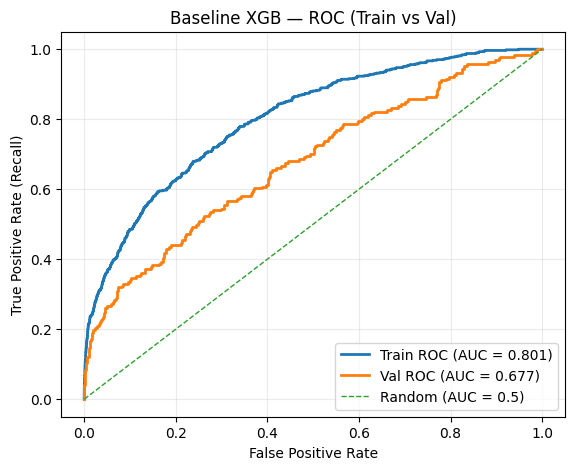

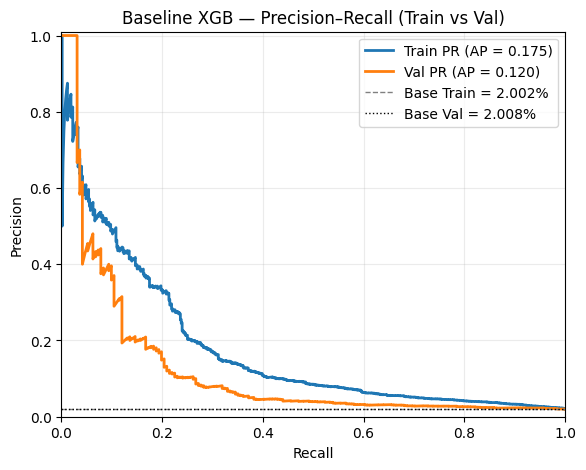

{'auc_train': 0.8013881964214871,
 'auc_val': 0.6773680298483815,
 'auc_gap': 0.12402016657310555,
 'prauc_train': 0.17522081860848776,
 'prauc_val': 0.12001417441289611,
 'prauc_gap': 0.05520664419559165,
 'prev_train': 0.020015423443634325,
 'prev_val': 0.020084121976866456}

In [19]:
rs_base = mt.randomized_search_xgb(
    X=X_tr, y=y_tr,
    base_params={},          # sin scale_pos_weight
    n_iter=40, 
    cv_splits=5,
    scoring="average_precision"
)
base_model = rs_base.best_estimator_
print("Baseline best params:", rs_base.best_params_)

res_base = mt.evaluate_model(
    base_model,
    splits={
        "train(refit)": (X_tr, y_tr),
        "val": (X_va, y_va),
        "test": (X_te, y_te),
    }
)
display(res_base)

metrics_gap = mt.plot_curves_train_val(
    model=base_model,
    X_train=X_tr, y_train=y_tr,
    X_val=X_va,   y_val=y_va,
    title_prefix="Baseline XGB",
    show=True
)
metrics_gap


## Modelo 2 — Balanceado por undersampling de la clase 0

In [23]:
# =========================
# Undersampling 50/50 en TRAIN
# =========================
from sklearn.utils import resample
import numpy as np
import pandas as pd

# Construyo un DF de trabajo con target
df_tr = X_tr.copy()
df_tr["target"] = y_tr

# Separo clases
df_pos = df_tr[df_tr["target"] == 1]
df_neg = df_tr[df_tr["target"] == 0]

n_pos = len(df_pos)
n_neg = len(df_neg)

if n_pos == 0:
    raise ValueError("No hay positivos en el set de entrenamiento.")
if n_neg == 0:
    raise ValueError("No hay negativos en el set de entrenamiento.")

# Undersample negativos hasta igualar a positivos (50/50)
df_neg_down = resample(
    df_neg,
    replace=False,
    n_samples=min(n_neg, n_pos),  # iguala a los positivos
    random_state=42,
)

# Conjunto balanceado 50/50
df_bal = pd.concat([df_pos, df_neg_down], axis=0).sample(frac=1.0, random_state=42)

X_tr_bal = df_bal.drop(columns="target")
y_tr_bal = df_bal["target"].astype(int)

print(
    f"Train original: pos={n_pos} ({n_pos/(n_pos+n_neg):.3%}), "
    f"neg={n_neg} ({n_neg/(n_pos+n_neg):.3%})"
)
print(
    f"Train balanceado: pos={int(y_tr_bal.sum())} "
    f"({y_tr_bal.mean():.3%}), neg={len(y_tr_bal)-int(y_tr_bal.sum())} "
    f"({1-y_tr_bal.mean():.3%})"
)


Train original: pos=571 (2.002%), neg=27957 (97.998%)
Train balanceado: pos=571 (50.000%), neg=571 (50.000%)


Fitting 5 folds for each of 40 candidates, totalling 200 fits
Balanced(50/50) best params: {'colsample_bytree': np.float64(0.6373608964950321), 'gamma': np.float64(1.6837302775431033), 'learning_rate': np.float64(0.03149193527717024), 'max_depth': 5, 'min_child_weight': 3, 'reg_alpha': np.float64(1.1044350847124695), 'reg_lambda': np.float64(1.1916467090032163), 'subsample': np.float64(0.8854835899772805)}


,auc,ks,prauc,n
split,,,,
test,0.680715,0.280535,0.092507,9509
train(refit-50/50),0.928009,0.695271,0.927489,1142
val,0.659003,0.242971,0.090401,9510


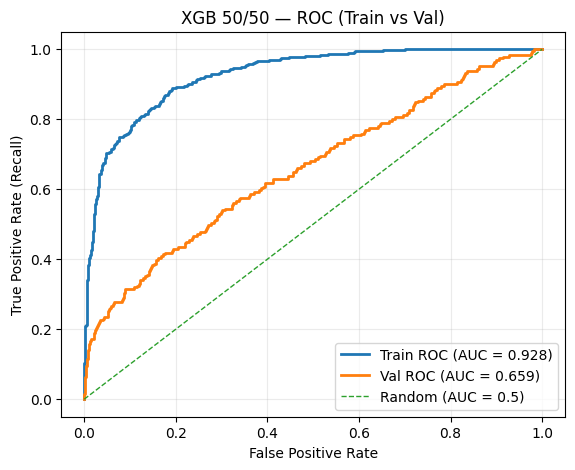

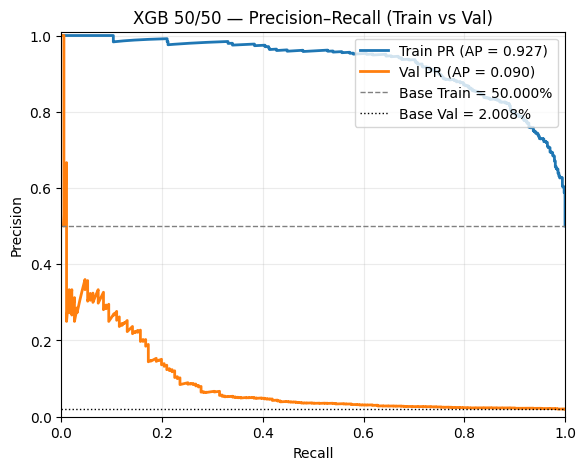

In [24]:
# =========================
# HPO en el set balanceado (PR-AUC)
# =========================
rs_bal50 = mt.randomized_search_xgb(
    X=X_tr_bal, y=y_tr_bal,
    base_params={},              # sin scale_pos_weight
    n_iter=40,                   # puedes subir a 80 si hay tiempo
    cv_splits=5,
    scoring="average_precision"
)
bal50_model = rs_bal50.best_estimator_
print("Balanced(50/50) best params:", rs_bal50.best_params_)

# =========================
# Evaluación en val/test (SIN balancear)
# =========================
res_bal50 = mt.evaluate_model(
    bal50_model,
    splits={
        "train(refit-50/50)": (X_tr_bal, y_tr_bal),
        "val": (X_va, y_va),
        "test": (X_te, y_te),
    }
)
display(res_bal50)


# =========================
# (Opcional) Curvas ROC/PR para ver overfitting del balanceado
# =========================
_ = mt.plot_curves_train_val(
    model=bal50_model,
    X_train=X_tr_bal, y_train=y_tr_bal,
    X_val=X_va,       y_val=y_va,
    title_prefix="XGB 50/50",
    show=True
)



## Write

In [29]:
import json
import joblib
import pandas as pd
from pathlib import Path

# --- rutas de salida
ART = DATA_PATH / "models"
ART.mkdir(parents=True, exist_ok=True)

# --- 1) Guardar modelos
path_base = ART / "xgb_baseline_rs.joblib"
path_bal  = ART / "xgb_balanced50_rs.joblib"
joblib.dump(base_model, path_base)
joblib.dump(bal50_model, path_bal)

['/Users/cristian/Library/CloudStorage/OneDrive-Personal/adeslas-interview/data/models/xgb_balanced50_rs.joblib']

In [30]:
# --- 2) Guardar features realmente usadas
(pd.Series(use_cols, name="feature")
   .to_csv(ART / "xgb_used_features.csv", index=False))

In [31]:
# --- 3) Guardar mejores hiperparámetros de cada búsqueda
with open(ART / "baseline_best_params.json", "w") as f:
    json.dump(rs_base.best_params_, f, indent=2)

with open(ART / "balanced50_best_params.json", "w") as f:
    json.dump(rs_bal50.best_params_, f, indent=2)

In [32]:
# --- 4) Métricas (AUC/KS/PR-AUC) en train/val/test

# Baseline
metrics_base = mt.evaluate_model(
    base_model,
    splits={
        "train(refit)": (X_tr, y_tr),
        "val":          (X_va, y_va),
        "test":         (X_te, y_te),
    }
)
metrics_base.to_csv(ART / "metrics_baseline.csv")

In [33]:
# Balanced 50/50: usa el train balanceado si está disponible, sino solo val/test
try:
    _X_train_bal, _y_train_bal = X_tr_bal, y_tr_bal  # definidos si balanceaste 50/50 antes
    splits_bal = {
        "train(refit-50/50)": (_X_train_bal, _y_train_bal),
        "val":                (X_va, y_va),
        "test":               (X_te, y_te),
    }
except NameError:
    splits_bal = {
        "val":  (X_va, y_va),
        "test": (X_te, y_te),
    }

metrics_bal = mt.evaluate_model(bal50_model, splits=splits_bal)
metrics_bal.to_csv(ART / "metrics_balanced50.csv")

In [34]:
# --- 5) Resumen en pantalla
print("✔ Modelos guardados:")
print(f"  - Baseline:   {path_base}")
print(f"  - Balanced50: {path_bal}")
print("✔ Features guardadas en:", ART / "xgb_used_features.csv")
print("✔ HPO guardado en:", ART / "baseline_best_params.json", "y", ART / "balanced50_best_params.json")
print("✔ Métricas guardadas en:", ART / "metrics_baseline.csv", "y", ART / "metrics_balanced50.csv")






✔ Modelos guardados:
  - Baseline:   /Users/cristian/Library/CloudStorage/OneDrive-Personal/adeslas-interview/data/models/xgb_baseline_rs.joblib
  - Balanced50: /Users/cristian/Library/CloudStorage/OneDrive-Personal/adeslas-interview/data/models/xgb_balanced50_rs.joblib
✔ Features guardadas en: /Users/cristian/Library/CloudStorage/OneDrive-Personal/adeslas-interview/data/models/xgb_used_features.csv
✔ HPO guardado en: /Users/cristian/Library/CloudStorage/OneDrive-Personal/adeslas-interview/data/models/baseline_best_params.json y /Users/cristian/Library/CloudStorage/OneDrive-Personal/adeslas-interview/data/models/balanced50_best_params.json
✔ Métricas guardadas en: /Users/cristian/Library/CloudStorage/OneDrive-Personal/adeslas-interview/data/models/metrics_baseline.csv y /Users/cristian/Library/CloudStorage/OneDrive-Personal/adeslas-interview/data/models/metrics_balanced50.csv


## Evaluación comparativa (AUC / KS / PR-AUC)

In [35]:
def eval_all(models: dict[str, object]) -> pd.DataFrame:
    rows = []
    for name, model in models.items():
        res = mt.evaluate_model(model, splits={"val": (X_va, y_va)}).reset_index()
        res["model"] = name
        rows.append(res)
    out = pd.concat(rows, ignore_index=True)
    return out.pivot(index="model", columns="split", values=["auc","ks","prauc"])

models = {
    "baseline": base_model,
     #"spw": spw_model,        # descomenta si lo entrenas
    "balanced": bal50_model,
}
display(eval_all(models))


,auc,ks,prauc
split,val,val,val
model,,,
balanced,0.659003,0.242971,0.090401
baseline,0.677368,0.261408,0.120014


# SHAP

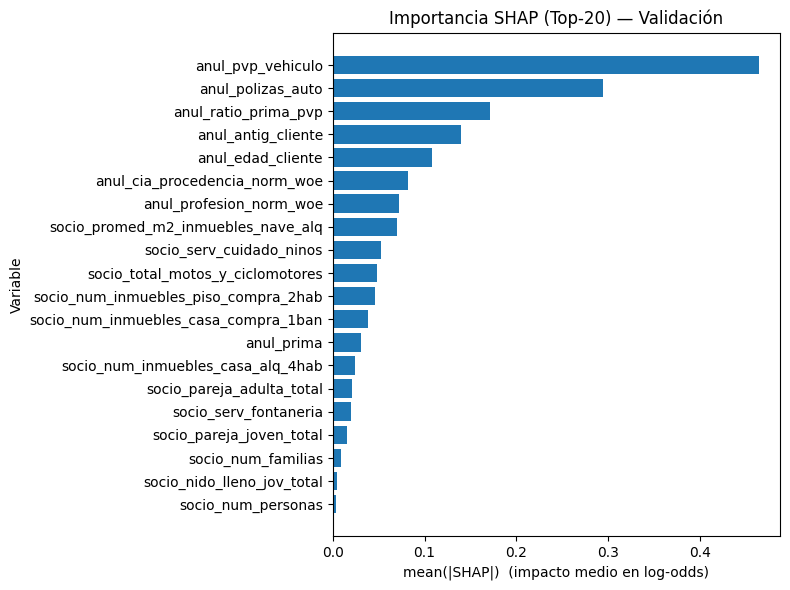

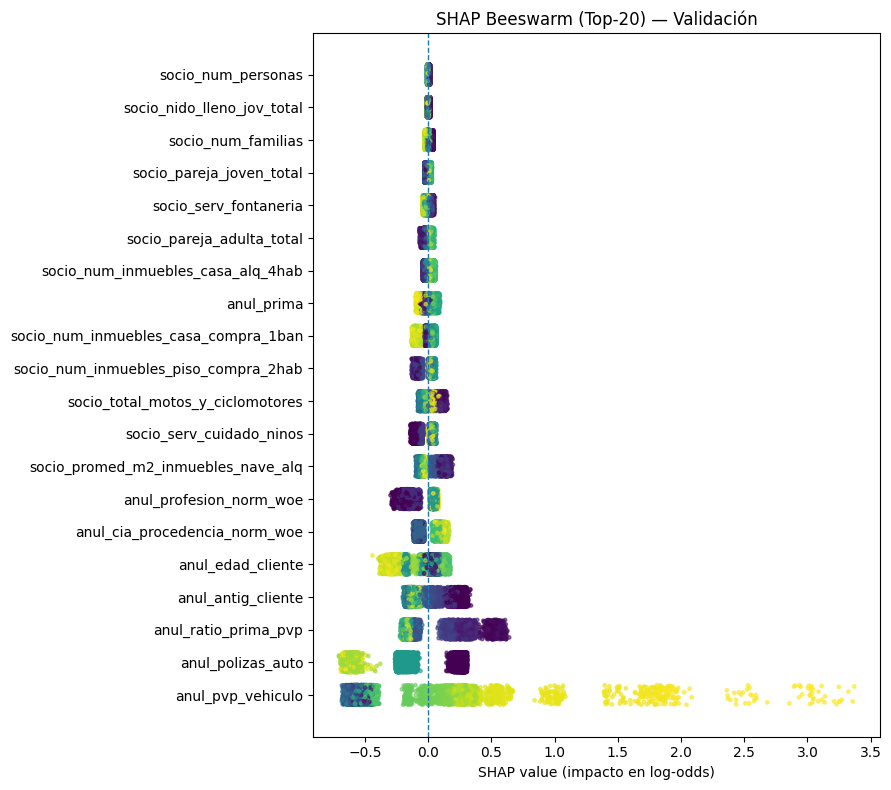

• Bar plot: mean(|SHAP|) mayor ⇒ mayor impacto global en el score.
• Beeswarm: puntos a la derecha (SHAP > 0) empujan a mayor prob. de anulación; a la izquierda (SHAP < 0) reducen.
• El color indica el valor relativo de la feature (percentil bajo→oscuro, alto→claro). Observa si valores altos/ bajos empujan positivamente o negativamente.


In [41]:
# =========================================
# Plots "típicos" de SHAP (sin librería shap)
# - Bar: mean(|SHAP|) por feature (top_k)
# - Beeswarm: dispersión de SHAP por feature (top_k), color por valor
# Requiere: base_model, X_va
# =========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

# 1) Alinear orden de columnas con el booster
booster = base_model.get_booster()
feat_order = booster.feature_names
Xv_ord = X_va[feat_order].copy()

# 2) SHAP values por observación (contribuciones); última col es el bias -> la quitamos
shap_all = booster.predict(xgb.DMatrix(Xv_ord), pred_contribs=True)  # (n, p+1)
shap_vals = shap_all[:, :-1]                                        # (n, p)
shap_df = pd.DataFrame(shap_vals, columns=feat_order)

# 3) Importancias: mean(|SHAP|)
imp = (np.abs(shap_vals).mean(axis=0))
imp_df = pd.DataFrame({"feature": feat_order, "mean_abs_shap": imp}) \
           .sort_values("mean_abs_shap", ascending=False, kind="mergesort") \
           .reset_index(drop=True)

# =========================
# Plot 1: Bar de importancias
# =========================
top_k = 20  # ajusta si quieres más/menos
imp_top = imp_df.head(top_k).iloc[::-1]  # invertimos para que la mayor quede arriba
plt.figure(figsize=(8, 6))
plt.barh(imp_top["feature"], imp_top["mean_abs_shap"])
plt.xlabel("mean(|SHAP|)  (impacto medio en log-odds)")
plt.ylabel("Variable")
plt.title(f"Importancia SHAP (Top-{top_k}) — Validación")
plt.tight_layout()
plt.show()

# =========================
# Plot 2: Beeswarm "tipo SHAP"
# =========================
# Construimos un beeswarm simple: para cada feature, graficamos sus SHAP con jitter vertical,
# y coloreamos por el valor de la feature (normalizado a percentiles).
def _percentile_scale(x: np.ndarray) -> np.ndarray:
    # escalar a [0,1] por percentiles para color
    ranks = pd.Series(x).rank(pct=True).to_numpy()
    return ranks

top_feats = imp_df["feature"].head(top_k).tolist()
shap_sub = shap_df[top_feats].to_numpy()
val_sub  = Xv_ord[top_feats].to_numpy()

# eje Y: índice de feature (0..top_k-1)
ypos = np.arange(len(top_feats))

plt.figure(figsize=(9, 8))
for i, f in enumerate(top_feats):
    sv = shap_sub[:, i]
    xv = val_sub[:, i]
    # jitter vertical para no superponer puntos
    jitter = (np.random.rand(len(sv)) - 0.5) * 0.6
    y = np.full_like(sv, fill_value=i, dtype=float) + jitter

    # color por percentil del valor de la feature (bajo=oscuro, alto=claro por colormap default)
    c = _percentile_scale(xv)

    plt.scatter(sv, y, s=6, alpha=0.6, c=c)  # sin especificar cmap → usa default

plt.yticks(ticks=ypos, labels=top_feats)
plt.xlabel("SHAP value (impacto en log-odds)")
plt.title(f"SHAP Beeswarm (Top-{top_k}) — Validación")
plt.axvline(0.0, ls="--", lw=1)
plt.tight_layout()
plt.show()

# ===== Tips de lectura impresos =====
print("• Bar plot: mean(|SHAP|) mayor ⇒ mayor impacto global en el score.")
print("• Beeswarm: puntos a la derecha (SHAP > 0) empujan a mayor prob. de anulación; a la izquierda (SHAP < 0) reducen.")
print("• El color indica el valor relativo de la feature (percentil bajo→oscuro, alto→claro). Observa si valores altos/ bajos empujan positivamente o negativamente.")


In [43]:
# ====== FIX SHAP: usar el MISMO orden de features que en entrenamiento ======
import xgboost as xgb
import numpy as np
import pandas as pd

from utils import model_training as mt
import importlib; importlib.reload(mt)

# 1) Obtener el orden correcto desde el booster
booster = base_model.get_booster()
feat_order = booster.feature_names  # orden usado al entrenar

# 2) Reordenar X_val con ese orden
Xv_ord = X_va[feat_order].copy()

# 3) SHAP importancias e interacciones agregadas (ya ordenado)
imp, inter = mt.shap_contribs(model=base_model, X=Xv_ord)
print("Top-10 por |SHAP| medio (val):")
display(imp.head(10))

top3_feats = imp["feature"].head(3).tolist()
print("Top-3 features:", top3_feats)

# 4) Obtener SHAP por observación (contribuciones) respetando el orden
dval = xgb.DMatrix(Xv_ord)  # MISMO ORDEN que feat_order
shap_all = booster.predict(dval, pred_contribs=True)  # (n, p+1)
shap_df = pd.DataFrame(shap_all[:, :-1], columns=feat_order)  # quitar bias, mismo orden

# 5) Perfil por cuantiles y dirección del efecto para cada top feature
from scipy.stats import spearmanr

def feature_shap_profile(X: pd.DataFrame, shap_df: pd.DataFrame, feat: str, q: int = 5) -> dict:
    df = pd.DataFrame({"value": X[feat].values, "shap": shap_df[feat].values}).dropna()
    df["q"] = pd.qcut(df["value"], q=q, duplicates="drop")
    tab = (df.groupby("q")
             .agg(value_mean=("value","mean"),
                  shap_mean=("shap","mean"),
                  shap_abs_mean=("shap", lambda s: np.mean(np.abs(s))),
                  n=("value","size"))
             .reset_index())
    rho, pval = spearmanr(df["value"], df["shap"])
    mean_low, mean_high = tab["shap_mean"].iloc[0], tab["shap_mean"].iloc[-1]
    if mean_high > mean_low:
        direction = "↑ valor → ↑ riesgo (SHAP ↑)"
    elif mean_high < mean_low:
        direction = "↑ valor → ↓ riesgo (SHAP ↓)"
    else:
        direction = "Efecto plano/no direccional"
    return {"table": tab, "rho": rho, "pval": pval, "direction": direction}

profiles = {}
for f in top3_feats:
    profiles[f] = feature_shap_profile(Xv_ord, shap_df, f, q=5)
    print(f"\n=== {f} ===")
    print(f"Dirección: {profiles[f]['direction']} | Spearman rho={profiles[f]['rho']:.3f} (p≈{profiles[f]['pval']:.1e})")
    display(profiles[f]["table"])

# 6) Interacciones (si tu build lo soporta)
if not inter.empty:
    print("\nTop-10 interacciones por |SHAP| medio (val):")
    display(inter.head(10))
    inter_top = inter[inter["feat_i"].isin(top3_feats) | inter["feat_j"].isin(top3_feats)].head(5)
    print("\nInteracciones que involucran top-3:")
    display(inter_top)

    # Tensor de interacciones usando el MISMO ORDEN
    inter_tensor = booster.predict(xgb.DMatrix(Xv_ord), pred_interactions=True)  # (n, p+1, p+1)
    inter_tensor = inter_tensor[:, :-1, :-1]
    col2idx = {c:i for i,c in enumerate(feat_order)}

    def interaction_2x2_summary(X: pd.DataFrame, shap_inter: np.ndarray, i: str, j: str) -> pd.DataFrame:
        mi, mj = X[i].median(), X[j].median()
        LL = (X[i] <= mi) & (X[j] <= mj)
        LH = (X[i] <= mi) & (X[j] >  mj)
        HL = (X[i] >  mi) & (X[j] <= mj)
        HH = (X[i] >  mi) & (X[j] >  mj)
        return pd.DataFrame({
            "low/low":  [float(np.mean(shap_inter[LL]))],
            "low/high": [float(np.mean(shap_inter[LH]))],
            "high/low": [float(np.mean(shap_inter[HL]))],
            "high/high":[float(np.mean(shap_inter[HH]))],
        }, index=[f"{i}×{j} | mean interaction SHAP"])

    print("\nResumen 2x2 (low/high por mediana) para interacciones top:")
    for _, row in inter_top.iterrows():
        i, j = row["feat_i"], row["feat_j"]
        ii, jj = col2idx[i], col2idx[j]
        pair_inter = inter_tensor[:, ii, jj]
        display(interaction_2x2_summary(Xv_ord, pair_inter, i, j))
else:
    print("\n(pred_interactions no disponible en esta build)")

print("\n--- Guía de lectura ---")
print("* SHAP > 0 empuja a mayor prob. de anulación; SHAP < 0 reduce la prob.")
print("* Tabla por cuantiles: compara SHAP medio en low→high para ver dirección.")
print("* Spearman ρ indica monotonicidad del efecto.")
print("* Interacciones 2x2: combinaciones low/high que elevan o mitigan riesgo.")


Top-10 por |SHAP| medio (val):


,feature,mean_abs_shap
0,anul_pvp_vehiculo,0.463621
1,anul_polizas_auto,0.294635
2,anul_ratio_prima_pvp,0.170953
3,anul_antig_cliente,0.140097
4,anul_edad_cliente,0.108567
5,anul_cia_procedencia_norm_woe,0.082038
6,anul_profesion_norm_woe,0.072300
7,socio_promed_m2_inmuebles_nave_alq,0.069926
8,socio_serv_cuidado_ninos,0.052427
9,socio_total_motos_y_ciclomotores,0.047801


Top-3 features: ['anul_pvp_vehiculo', 'anul_polizas_auto', 'anul_ratio_prima_pvp']

=== anul_pvp_vehiculo ===
Dirección: ↑ valor → ↑ riesgo (SHAP ↑) | Spearman rho=0.687 (p≈0.0e+00)


/var/folders/7d/dkd8qgdn6s94ktjnvzzwq5rw0000gn/T/ipykernel_9595/3955772904.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tab = (df.groupby("q")


,q,value_mean,shap_mean,shap_abs_mean,n
0,"(0.822, 2866.007]",1417.558775,-0.535018,0.535018,1639
1,"(2866.007, 5786.998]",4262.644006,-0.586698,0.586698,1639
2,"(5786.998, 9177.017]",7442.421265,-0.547409,0.547409,1638
3,"(9177.017, 14096.303]",11415.242478,-0.399897,0.410876,1639
4,"(14096.303, 75734.904]",19930.467163,0.576001,0.576001,1639



=== anul_polizas_auto ===
Dirección: ↑ valor → ↓ riesgo (SHAP ↓) | Spearman rho=-0.917 (p≈0.0e+00)


/var/folders/7d/dkd8qgdn6s94ktjnvzzwq5rw0000gn/T/ipykernel_9595/3955772904.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tab = (df.groupby("q")


,q,value_mean,shap_mean,shap_abs_mean,n
0,"(-0.001, 1.0]",0.423439,0.069434,0.229363,7850
1,"(1.0, 5.0]",2.304819,-0.603296,0.603296,1660



=== anul_ratio_prima_pvp ===
Dirección: ↑ valor → ↓ riesgo (SHAP ↓) | Spearman rho=-0.767 (p≈0.0e+00)


/var/folders/7d/dkd8qgdn6s94ktjnvzzwq5rw0000gn/T/ipykernel_9595/3955772904.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tab = (df.groupby("q")


,q,value_mean,shap_mean,shap_abs_mean,n
0,"(-0.00099786, 0.0137]",0.007369,0.327249,0.327249,1639
1,"(0.0137, 0.0302]",0.021461,-0.084170,0.113147,1639
2,"(0.0302, 0.0587]",0.042808,-0.165109,0.165109,1638
3,"(0.0587, 0.132]",0.087044,-0.168769,0.168769,1639
4,"(0.132, 690.004]",1.422776,-0.162549,0.162549,1639



Top-10 interacciones por |SHAP| medio (val):


,feat_i,feat_j,mean_abs_interaction
0,anul_pvp_vehiculo,anul_polizas_auto,0.027105
1,anul_pvp_vehiculo,anul_cia_procedencia_norm_woe,0.011611
2,anul_pvp_vehiculo,anul_profesion_norm_woe,0.009306
3,anul_pvp_vehiculo,anul_antig_cliente,0.007751
4,anul_pvp_vehiculo,anul_edad_cliente,0.006790
5,anul_polizas_auto,anul_edad_cliente,0.006624
6,anul_antig_cliente,socio_promed_m2_inmuebles_nave_alq,0.006537
7,anul_cia_procedencia_norm_woe,anul_edad_cliente,0.006387
8,anul_polizas_auto,anul_prima,0.006189
9,anul_polizas_auto,anul_antig_cliente,0.006062



Interacciones que involucran top-3:


,feat_i,feat_j,mean_abs_interaction
0,anul_pvp_vehiculo,anul_polizas_auto,0.027105
1,anul_pvp_vehiculo,anul_cia_procedencia_norm_woe,0.011611
2,anul_pvp_vehiculo,anul_profesion_norm_woe,0.009306
3,anul_pvp_vehiculo,anul_antig_cliente,0.007751
4,anul_pvp_vehiculo,anul_edad_cliente,0.006790



Resumen 2x2 (low/high por mediana) para interacciones top:


,low/low,low/high,high/low,high/high
anul_pvp_vehiculo×anul_polizas_auto | mean interaction SHAP,-0.001587,-0.001359,0.00031,-0.003704


,low/low,low/high,high/low,high/high
anul_pvp_vehiculo×anul_cia_procedencia_norm_woe | mean interaction SHAP,-0.014259,0.017474,-0.001952,0.002428


,low/low,low/high,high/low,high/high
anul_pvp_vehiculo×anul_profesion_norm_woe | mean interaction SHAP,0.002046,-0.006043,-0.000109,0.00132


,low/low,low/high,high/low,high/high
anul_pvp_vehiculo×anul_antig_cliente | mean interaction SHAP,0.005176,-0.005005,0.001149,-0.002317


,low/low,low/high,high/low,high/high
anul_pvp_vehiculo×anul_edad_cliente | mean interaction SHAP,0.00557,-0.005462,0.001455,-0.001868



--- Guía de lectura ---
* SHAP > 0 empuja a mayor prob. de anulación; SHAP < 0 reduce la prob.
* Tabla por cuantiles: compara SHAP medio en low→high para ver dirección.
* Spearman ρ indica monotonicidad del efecto.
* Interacciones 2x2: combinaciones low/high que elevan o mitigan riesgo.


# Interpretación de factores principales de fuga

## 1. Clientes con vehículos de mayor valor (`anul_pvp_vehiculo`)
- A medida que sube el precio del vehículo, la probabilidad de anulación también aumenta.  
- **Perfil típico**: clientes con coches de gama media/alta son más sensibles al precio y tienden a comparar más.  

## 2. Clientes con varias pólizas de auto (`anul_polizas_auto`)
- Tener más de una póliza de auto reduce fuertemente la probabilidad de fuga.  
- **Perfil típico**: familias o particulares con más de un vehículo asegurado muestran **mayor fidelidad** y menor propensión a cancelar.  

## 3. Relación prima/PVP vehículo (`anul_ratio_prima_pvp`)
- Si la prima es percibida como proporcionada al valor del vehículo, el riesgo de fuga es menor.  
- Cuando el ratio es extremadamente bajo o inconsistente, se asocia a más riesgo (posible señal de pólizas menos rentables o clientes poco comprometidos).  

---

## Interacciones relevantes

- **Vehículo caro × aseguradora de origen (`anul_cia_procedencia_norm_woe`)**  
  - El efecto del precio del vehículo se modula según la aseguradora de la que proviene el cliente.  
  - Los clientes procedentes de compañías con WOE alto (históricamente más riesgosas) y con vehículos caros muestran mayor propensión a cancelar.  

- **Vehículo caro × profesión (`anul_profesion_norm_woe`)**  
  - El efecto del precio del vehículo se modula según la profesión del cliente.  
  - Profesiones con WOE alto (más propensas a fuga) amplifican el riesgo en clientes con vehículos caros.  

---

## Conclusión para negocio

- **Mayor riesgo**: clientes con **vehículos caros**, **una sola póliza**, y que además pertenecen a **aseguradoras de origen o profesiones con WOE alto**.  
- **Menor riesgo**: clientes **multipóliza**, con **vehículos de valor medio**, y primas ajustadas a su PVP.  
- **Acción recomendada**:  
  - Focalizar campañas de retención en **clientes de alto valor de vehículo que solo tengan 1 póliza**.  
  - Reforzar programas de fidelización multiproducto (beneficios a clientes con más de una póliza).  
  - Considerar el **origen de la aseguradora** y la **profesión** como moduladores del riesgo al priorizar a quién ofrecer incentivos.  


# Métricas utilizadas para evaluar el modelo

Para determinar si el modelo de XGBoost es apropiado en la predicción de la fuga de clientes, hemos utilizado un conjunto de métricas complementarias:

## 1. AUC-ROC (Área bajo la curva ROC)
- **Qué mide**: capacidad global de discriminación del modelo entre clientes que cancelan (churn) y los que no.  
- **Interpretación**: valores >0.65 ya indican poder predictivo razonable; un modelo aleatorio tendría AUC≈0.50.  
- **Uso**: garantiza que el modelo rankea a los clientes de forma útil a lo largo de todo el espectro de umbrales.

## 2. KS Statistic (Kolmogorov-Smirnov)
- **Qué mide**: máxima separación entre la distribución acumulada de positivos (churners) y negativos (no churners).  
- **Interpretación**: cuanto mayor el KS, mejor capacidad de separación. Valores >0.2 son aceptables en riesgo/retención.  
- **Uso**: métrica clásica en scoring de clientes, fácil de explicar a negocio.

## 3. PR-AUC (Área bajo la curva Precision-Recall)
- **Qué mide**: calidad de la predicción enfocada en la **clase minoritaria** (clientes que cancelan).  
- **Interpretación**: es crítica en contextos de desbalanceo severo; un clasificador aleatorio tendría PR-AUC≈%churn (ej: si churn=2%, PR-AUC≈0.02).  
- **Uso**: nos permite validar que el modelo realmente concentra churners en los primeros percentiles de score.

---

## Conclusión
- **AUC** y **KS** muestran que el modelo generaliza y discrimina mejor que el azar.  
- **PR-AUC** confirma que, a pesar del desbalanceo, el modelo concentra churners en los percentiles altos.  
- Al definir umbrales, se monitorizarán **precision**, **recall** y **Fβ**, que permiten alinear el uso del modelo con los objetivos de negocio (minimizar gasto en incentivos vs maximizar retención).  


Mini-checklist para tu entrega

✅ Comparativa baseline vs balanced (tabla val).

✅ Umbral elegido con precision mínima y coste.

✅ Ensamble con métricas y coste.

✅ Top factores/interacciones (SHAP) para explicar perfiles de riesgo.

✅ Planes de campaña (top-k% y por presupuesto) con trade-offs.

Si luego quieres correr la versión con scale_pos_weight, descomenta el bloque del Modelo 2 y añade sus probabilidades al ensamble.